In [24]:
import pandas as pd
import re 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt # type: ignore

df = pd.read_csv("Phishing_Email.csv")
df = df.drop('Unnamed: 0', axis=1)
df.dropna(inplace = True)

In [25]:
def expert_system_classification(row):
    # Storing the email texts in a variable called text for easier use later.
    text = str(row["Email Text"]).lower()
    # Words that sound an immediate red flag upon detection in the text
    high_risk_words = [
            "Account suspended", "Account validation", "Activate", "Action required", "Alert",
            "Amount owed", "Application expired", "Bank details", "Be quick", "Blacklisted",
            "Click below", "Click here", "Compensation", "Confirm your account", "Confirm your identity",
            "Confirm your password", "Credit card information", "Danger", "Deactivated", "Exclusive offer",
            "Expired", "Free gift", "Free money", "Gift card", "Instant", "IRS", "Limited time", "Login",
            "Lottery", "Offer expires", "Order confirmation", "Overdue", "Pay now", "Payment details",
            "Password reset", "Payment failed", "Prize claim", "Refund", "Risk-free", "Secure your account",
            "Security alert", "Send money", "Suspicious activity", "Terms and conditions", "Verification required",
            "Verify", "Winner", "You have been selected", "Urgent action required", "Unauthorized access",
            "Unsecured account", "Urgent update", "We’ve detected suspicious activity", "Warning",
            "Your account has been compromised", "You need to take immediate action", "Final warning",
            "Click to verify", "Limited availability", "Won't last long"
    ]
    # Words that indicate a thorough inspection to be conducted when seen in an email
    medium_risk_words = [

            "act now", "final notice", "confirm your account", "verify account",
            "login", "password", "account suspended", "payment failure", "credit card", "reset password",
            "security notice", "win", "prize", "free gift", "bank account", "unauthorized access", "click here",
            "limited time", "special promotion", "offer expires", "last chance", "bonus", "reward", "giveaway", "urgent", "immediately",
            "invoice", "billing", "balance", "deposit", "settlement", "refund", "IRS", "customer care", 
            "support team", "service provider", "account team", "dating","escort"
    ]
    risk_words=[]
    # Suspicious web extensions, shortners and even file extensions
    web_extensions = [".xyz", ".top", ".club", ".ru", ".cn", ".info", ".tk", ".party", ".buzz", ".email", ".me"]
    web_shortners = ["bit.ly", "tinyurl", "ow.ly"]
    file_extensions = [".exe", ".zip", ".rar", ".scr", ".js", ".vbs", ".docm", ".pdf", ".iso", ".cmd", ".bat", ".dll", ".gif", ".html", ".htm"]

    # if any high risk word is detected in an email, label it as a Phishing Email immediately
    if any(keyword in text for keyword in high_risk_words):
        return "Phishing Email"
    
    # if any medium risk word is detected, go through with the other steps.
    if any(keyword in text for keyword in medium_risk_words):
        # RegEx for urls where it only captures whatever comes after the "www."
        urls = re.findall(r'http[s]?://(?:www\.)?(\S+)', text)
        # if there are any web or file extentions from the list above in the domain name then it is a Phishing email
        if any(ext in url for url in urls for ext in web_extensions) or \
           any(ext in text for ext in file_extensions):
            return "Phishing Email"
    
    # Searches for scripts in the Email
    if re.search(r'<a|<iframe|<script', text):
        return "Phishing Email"
    
    # Searches for any shortners that were in the list above or the use of excessive !!! or $$ signs in the text
    if any(shortener in text for shortener in web_shortners) or "!!!" in text or "$$" in text:
        return "Phishing Email"

    return "Safe Email"

In [ ]:
def scoring_system_classification(row):

    text = str(row["Email Text"]).lower()

    spam_words=[
    # Urgency and Action
    "immediate action required", "final notice", "immediate response", "confirm your account", 
    "update now", "reset password", "security notice", "last chance", "expires soon", "act now", 
    "update payment", "payment failure", "verify account",
    
    # Financial Incentives
    "exclusive offer", "special promotion", "offer expires", "act fast", "low price", "discount", 
    "offer expires", "clearance", "unlimited promo",
    
    # Account and Verification
    "verify account", "account access", "account suspended", "bank account", "confirm identity", 
    "security check", "secure your account", "unauthorized access", "re-authenticate", "verify identity",
    
    # Financial/Transactional
    "pending transaction", "credit card", "debit", "loan", "bank transfer", "refund", "tax", 
    "financial fee", "invoice", "billing", "payment", "due now", "outstanding", "overdue", "balance", 
    "settlement", "account balance",
    
    # Suspicious Attachments
    "open attachment", "click link", "view document", "open file", "secure document", "pdf invoice", 
    "attachment included", "see attachment", "click to open",
    
    # Specific Keywords
    "microsoft support", "apple id", "paypal", "netflix", "amazon", "google security", "service provider", 
    "account team", "support team", "customer care", "click here", "click below", "verify now", 
    "log in here", "sign in", "access your account", "safe secure", "banking", "validate", "validate", 
    "escort", "mature", "webcam"
]  
    explicit_words = [
        #Explicit words meant to target only 18+ emails. Please do not read teacher
        "Ã", "Â", "€™", "Ã©", "Ã²", "horny", "adult", "porn", "sex", "xxx", "erotic", "nude", "shemale", "explicit", 
        "pornography",  "strip", "fetish", "hentai", "bdsm", "sexual enhancement", "viagra", "hookup","babe",
        "cum","suck off","sexy","empty"
]

    web_extensions = [".xyz", ".top", ".club", ".ru", ".cn", ".info", ".tk", ".party", ".buzz", ".email", ".me"]
    web_shortners = ["bit.ly", "tinyurl", "ow.ly"]  
    file_extensions = [".exe", ".zip", ".rar", ".scr", ".js", ".vbs", ".docm", ".pdf", ".iso", ".cmd", ".bat", ".dll", ".gif", ".html", ".htm"]

    # Initial score 
    score = 0

    # Everytime a word is matched from the list above a single score point is added
    score += sum(1 for keyword in spam_words if keyword in str(row["Email Text"]).lower())

    # if the email text contains these explicit words then add 5 points
    if text in explicit_words:
        score += 5
    
    # RegEx for urls where it only captures whatever comes after the "www."
    urls = re.findall(r'http[s]?://(?:www\.)?(\S+)', text)
    # if there are any web or file extentions from the list above in the domain name then it is a Phishing email
    if any(ext in url for url in urls for ext in web_extensions) or \
       any(ext in text for ext in file_extensions):
        score += 1

    # For any excessive capitalization and punctuation as well as "!!!" in the text the score added is also 1
    if re.search(r'\b[A-Z]{3,}\b', str(row["Email Text"])):
        score += 1

    # For scripts it will be 2 points
    if re.search(r'<a|<script|<iframe', text):
        score += 1
    
    # Shortners with 1 point
    if any(shortener in text for shortener in web_shortners) or "!!!" in text or "$$" in text:
        score += 1

    repeated_keywords = sum(text.count(keyword) for keyword in spam_words)
    score += repeated_keywords

    # Score Threshold is set greater than or equal to 5
    return "Phishing Email" if score >= 3 else "Safe Email"

In [27]:
# Making a new column in the table and applying both rules inside, with column concatenation
df["expert_system_prediction"] = df.apply(expert_system_classification, axis=1)
df["scoring_system_prediction"] = df.apply(scoring_system_classification, axis=1)

# Checking the accuracy of both rules by comparing it to an existing classification.
expert_accuracy = (df["expert_system_prediction"] == df["Email Type"]).mean()
print(f"Expert System Accuracy: {expert_accuracy * 100:.2f}%")

scoring_accuracy = (df["scoring_system_prediction"] == df["Email Type"]).mean()
print(f"Scoring System Accuracy: {scoring_accuracy * 100:.2f}%")

Expert System Accuracy: 60.92%
Scoring System Accuracy: 61.93%



Expert System Classification Report:
                precision    recall  f1-score   support

    Safe Email       0.52      0.05      0.09      7312
Phishing Email       0.61      0.97      0.75     11322

      accuracy                           0.61     18634
     macro avg       0.57      0.51      0.42     18634
  weighted avg       0.58      0.61      0.49     18634


Scoring System Classification Report:
                precision    recall  f1-score   support

    Safe Email       0.53      0.26      0.35      7312
Phishing Email       0.64      0.85      0.73     11322

      accuracy                           0.62     18634
     macro avg       0.59      0.56      0.54     18634
  weighted avg       0.60      0.62      0.58     18634



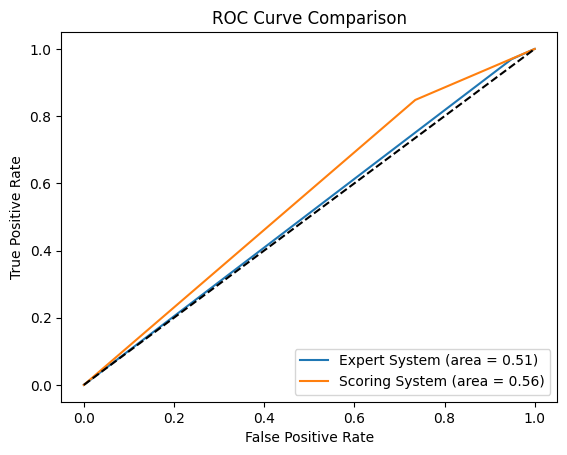

In [28]:
# Generate classification report for expert system
print("\nExpert System Classification Report:")
print(classification_report(df["Email Type"], df["expert_system_prediction"], target_names=["Safe Email", "Phishing Email"]))

# Generate classification report for scoring system
print("\nScoring System Classification Report:")
print(classification_report(df["Email Type"], df["scoring_system_prediction"], target_names=["Safe Email", "Phishing Email"]))


# Binarizing for ROC
df["email_type_binary"] = label_binarize(df["Email Type"], classes=["Phishing Email", "Safe Email"])
df["expert_binary"] = label_binarize(df["expert_system_prediction"], classes=["Phishing Email", "Safe Email"])
df["scoring_binary"] = label_binarize(df["scoring_system_prediction"], classes=["Phishing Email", "Safe Email"])

# Plot ROC for expert system
fpr, tpr, _ = roc_curve(df['email_type_binary'], df['expert_binary'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Expert System (area = {roc_auc:.2f})')

# Plot ROC for scoring system
fpr, tpr, _ = roc_curve(df['email_type_binary'], df['scoring_binary'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Scoring System (area = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()